#### Helper Functions

In [ ]:

####################################################################################################
               # HELPER FUNCTIONS FOR THE NOTEBOOK
####################################################################################################

import numpy as np

def is_positive_semi_definite(matrix):
    """Check if a matrix is positive semi-definite."""
    eigenvalues = np.linalg.eigvalsh(matrix)
    return np.all(eigenvalues >= -1e-10)  # Allowing for numerical precision issues

def sample_covariance_estimator(X):
    """Estimate the covariance matrix of a data matrix."""
    n = X.shape[0]
    covariance_matrix = np.dot(X.T, X) / n
    
    return covariance_matrix

def generate_low_rank_data(n_features, n_samples, rank):
    """Generate a sample data matrix with a specified low rank."""
    rank = min(rank, n_features, n_samples)
    A = np.random.randn(n_features, rank) @ np.random.randn(rank, n_samples)
    
    return A

def compare_eigenvalues(eigvals_sample, eigvals_nystrom, k):
    """Compare top k eigenvalues of sample covariance matrix and Nyström approximation."""
    eigvals_sample = eigvals_sample[:k]
    eigvals_nystrom = eigvals_nystrom[:k]
    relative_error = np.linalg.norm(eigvals_sample - eigvals_nystrom) / np.linalg.norm(eigvals_sample)
    return relative_error

def compare_eigenvectors(eigvecs_sample, eigvecs_nystrom, k):
    """Compare top k eigenvectors of sample covariance matrix and Nyström approximation."""
    eigvecs_sample = eigvecs_sample[:, :k]
    eigvecs_nystrom = eigvecs_nystrom[:, :k]
    # Adjust signs
    for i in range(eigvecs_sample.shape[1]):
        if np.dot(eigvecs_sample[:, i], eigvecs_nystrom[:, i]) < 0:
            eigvecs_nystrom[:, i] *= -1
    
    frobenius_norm = np.linalg.norm(eigvecs_sample - eigvecs_nystrom, 'fro') / np.linalg.norm(eigvecs_sample, 'fro')
    return frobenius_norm

#### Nystrom Covariance Estimator

In [3]:

####################################################################################################
               # Nyström PCA
####################################################################################################

def nystrom_covariance_estimator(X, indices):
   """
   Estimates the covariance matrix of a data matrix using the Nyström method.

   Parameters:
   -----------
   X : numpy.ndarray
       The input data matrix of shape (n, p), where n is the number of samples
       and p is the number of features.
   indices : numpy.ndarray
       The indices of the landmark points to be used in the Nyström method.

   Returns:
   --------
   Sigma_hat : numpy.ndarray
       The estimated covariance matrix of shape (p, p).
   """
   n, p = X.shape      # n: number of samples, p: number of features

   # Step 1: Use the provided landmark indices
   Y = X[:, indices]      # Y.shape = (n, num_landmarks)

   # Step 2: Compute the orthogonal projection matrix P using the pseudoinverse
   YTY = Y.T @ Y
   YTY_pinv = np.linalg.pinv(YTY)
   P = Y @ (YTY_pinv @ Y.T)    # P.shape = (n, n)

  
   Sigma_hat = X.T @ P @ X / n    # Sigma_hat.shape = (p, p)
  
   return Sigma_hat

#### Nystrom PCA

In [4]:
def nystrom_pca(X, indices, num_landmarks):
   """
   Estimates the principal components of a data matrix using the Nyström method.

   Args:
   X (numpy.ndarray): Input data matrix of shape (n, p)
   indices (numpy.ndarray): Indices for landmark points
   num_landmarks (int): Number of landmark points

   Returns:
   tuple: Eigenvalues and eigenvectors of the approximated covariance matrix
   """
   n, p = X.shape  # n: number of samples, p: number of features
  
   # Step 1: Extract landmark points
   Y = X[:, indices]  # Y.shape = (n, num_landmarks)

   # Step 2: Define complement set J and corresponding data
   indices_J = np.setdiff1d(np.arange(p), indices)
   Z = X[:, indices_J]  # Z.shape = (n, p - num_landmarks)

   # Step 3: Compute thin SVD of Y
   U_Y, D_Y, V_Y_T = np.linalg.svd(Y, full_matrices=False)
  
   # Step 4: Construct W_Y and W_Z
   W_Y = (1 / np.sqrt(n)) * np.diag(D_Y) @ V_Y_T
   W_Z = (1 / np.sqrt(n)) * U_Y.T @ Z

   # Step 5: Initialize and populate W
   W = np.zeros((num_landmarks, p))
   W[:, indices] = W_Y 
   W[:, indices_J] = W_Z
   # Sigma_hat = W.T @ W

   # Step 6: Perform thin SVD on W
   U, Lambda, V_T = np.linalg.svd(W, full_matrices=False)

   # Step 7: Compute eigenvalues and eigenvectors
   eigenvalues = Lambda**2
   eigenvectors = V_T.T

   return eigenvalues, eigenvectors

#### Sampling Methods

In [5]:
def uniform_random_sample(X, num_landmarks, replace=False):
   """
       Samples indices uniformly at random from a data matrix.
   """
   n, p = X.shape
   indices = np.random.choice(p, num_landmarks, replace=replace)
   return indices

In [6]:
def column_norm_sample(X, num_landmarks, replace=False):
   """Samples indices based on the column norms of a data matrix."""
   n, p = X.shape
  
   # Step 1: Compute the column norms
   column_norms = np.linalg.norm(X, axis=0)

   # Step 2: Compute the probabilities
   probabilities = column_norms ** 2
   probabilities /= np.sum(probabilities)

   # Step 3: Sample indices based on the probabilities
   indices = np.random.choice(p, num_landmarks, replace=replace, p=probabilities)

   return indices

In [7]:
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import eigsh

def recursive_rls_sample(X, num_landmarks=None, replace=False, accelerated_flag=False):
   """
   Perform recursive leverage score sampling on the input matrix X.

   Parameters:
   -----------
   X : numpy.ndarray
       Input matrix of shape (n, p), where n is the number of features and p is the number of data points.
   num_landmarks : int, optional
       Number of landmarks to sample. If None, it's set to ceil(sqrt(p)).
   replace : bool, optional
       Not used in the current implementation.
   accelerated_flag : bool, optional
       If True, use an accelerated version of the algorithm.

   Returns:
   --------
   r_ind : numpy.ndarray
       Indices of the selected columns (landmarks).
   """
   n, p = X.shape  # n is the number of features, p is the number of data points

   # Set the number of landmarks
   if num_landmarks is None:
       s = int(np.ceil(np.sqrt(p)))
   else:
       s = num_landmarks

   # Define the kernel function for columns
   kernel_func = lambda X, col_ind1, col_ind2: (
       X[:, col_ind1].T @ X[:, col_ind2] if len(col_ind2) > 0
       else np.sum(X[:, col_ind1] ** 2, axis=0)
   )

   # Set parameters based on whether acceleration is used
   if not accelerated_flag:
       s_level = s
   else:
       s_level = int(np.ceil(np.sqrt((p * s + s ** 3) / (4 * p))))

   oversamp = np.log(s_level)
   k = int(np.ceil(s_level / (4 * oversamp)))
   n_levels = int(np.ceil(np.log(p / s_level) / np.log(2)))

   # Generate a random permutation of column indices
   perm = np.random.permutation(p)

   # Create a list of decreasing sizes for each level
   l_size = [p]
   for _ in range(n_levels):
       l_size.append(int(np.ceil(l_size[-1] / 2)))

   # Initialize sampling indices and weights
   samp = np.arange(l_size[-1])
   r_ind = perm[samp]
   weights = np.ones(len(r_ind))

   # Compute the diagonal of the kernel matrix
   k_diag = kernel_func(X, np.arange(p), [])

   # Main loop: iterate through levels from bottom to top
   for l in range(n_levels, 0, -1):
       r_ind_curr = perm[:l_size[l - 1]]
       KS = kernel_func(X, r_ind_curr, r_ind)
       SKS = KS[samp, :]
       SKSn = SKS.shape[0]

       # Compute lambda (regularization parameter)
       if k >= SKSn:
           lambda_ = 1e-6
       else:
           diag_SKS = np.diag(SKS)
           diag_sum = np.sum(diag_SKS * weights ** 2)
           SKS_weighted = SKS * weights[np.newaxis, :]
           eigvals = eigsh(
               SKS_weighted @ SKS_weighted.T, k=k, which='LM', return_eigenvectors=False
           )
           eig_sum = np.sum(np.abs(eigvals))
           lambda_ = (diag_sum - eig_sum) / k

       # Compute the inverse of (SKS + lambda * I)
       R = linalg.inv(SKS + np.diag(lambda_ * weights ** (-2)))

       # Compute residuals
       residuals = k_diag[r_ind_curr] - np.sum((KS @ R) * KS, axis=1)

       # Sample columns based on leverage scores
       if l != 1:
           # Compute leverage scores
           levs = np.maximum(
               0,
               np.minimum(
                   1,
                   oversamp * (1 / lambda_) * np.maximum(0, residuals)
               ),
           )
           levs_sum = np.sum(levs)
          
           # Sample columns
           if levs_sum == 0 or np.count_nonzero(levs) < s_level:
               samp = np.random.choice(l_size[l - 1], size=s_level, replace=False)
           else:
               samp = np.random.choice(
                   l_size[l - 1], size=s_level, replace=False, p=levs / levs_sum
               )
          
           # Update weights
           weights = np.sqrt(1 / np.maximum(levs[samp], 1e-12))  # Avoid division by zero
       else:
           # Final sampling step
           levs = np.maximum(
               0, np.minimum(1, (1 / lambda_) * np.maximum(0, residuals))
           )
           levs_sum = np.sum(levs)
          
           # Sample columns
           if levs_sum == 0 or np.count_nonzero(levs) < s:
               samp = np.random.choice(p, size=s, replace=False)
           else:
               samp = np.random.choice(
                   p, size=s, replace=False, p=levs / levs_sum
               )

           # Update weights
           weights = np.sqrt(1 / np.maximum(levs[samp], 1e-12))

       # Update r_ind with the newly sampled columns
       r_ind = r_ind_curr[samp]

   return r_ind

#### Error Statistics

In [64]:
def bias(Sigma, X, indices, k):
    """
    Computes the bias of the Nyström covariance estimator.

    Args:
    Sigma (np.array): The sample covariance matrix
    X (np.array): The data matrix
    indices (np.array): Indices of selected landmark points
    k (int): Number of landmark points

    Returns:
    np.array: The bias matrix
    """
    n, p = X.shape
    I = indices
    J = np.setdiff1d(np.arange(p), I)  # Indices not in I

    # Extract submatrices
    Sigma_I = Sigma[np.ix_(I, I)]    # Covariance of landmark points
    Sigma_J = Sigma[np.ix_(J, J)]    # Covariance of non-landmark points
    Sigma_IJ = Sigma[np.ix_(I, J)]   # Cross-covariance

    # Compute Schur complement
    Schur_complement = Sigma_J - Sigma_IJ.T @ np.linalg.inv(Sigma_I) @ Sigma_IJ
    
    # Compute bias for non-landmark points
    B_J = ((n - k) / n) * Schur_complement

    # Create full bias matrix
    Bias = np.zeros_like(Sigma)
    Bias[np.ix_(J, J)] = B_J
    
    return Bias

In [47]:
def mse(Sigma, Sigma_I, X, k):
    """
    Computes the mean square error (MSE) of the Nyström covariance estimator.

    Parameters:
    Sigma (numpy.ndarray): The true covariance matrix.
    Sigma_hat (numpy.ndarray): The estimated covariance matrix using Nyström method.
    X (numpy.ndarray): The data matrix.
    k (int): The number of landmarks used in the Nyström method.

    Returns:
    float: The difference between the MSE of the Nyström estimator and the sample covariance estimator.
    """
    n, p = X.shape

    # MSE of the sample covariance estimator of the Schur complement
    MSE_Sigma_I_Schur = (1 / (n - k)) * (np.trace(Sigma_I @ Sigma_I) + np.trace(Sigma_I) ** 2)

    # MSE of the sample covariance estimator
    MSE_Sigma = (1 / n) * (np.trace(Sigma @ Sigma) + np.trace(Sigma) ** 2)

    # Compute the MSE of the Nyström covariance estimator
    MSE = MSE_Sigma + (((n - k)** 2) / n ** 2) * (np.linalg.norm(Sigma_I, 'fro') - MSE_Sigma_I_Schur)

    return MSE, MSE_Sigma

### Tests

In [9]:
import pandas as pd

X = pd.read_pickle('russell_minute_data.pkl')
print("Data Shape: ", X.shape)
print("Data: ", X.head(2))

Data Shape:  (180, 1014)
Data:                                 AADI       AAN     AAON  AAT  ABCB      ABCL  \
2024-08-06 09:30:00-04:00 -0.021277 -0.001505  0.00296  0.0   0.0 -0.016129   
2024-08-06 09:35:00-04:00 -0.021277 -0.001505  0.00296  0.0   0.0 -0.016129   

                               ABG      ABM       ABR      ABSI  ...  NRIX  \
2024-08-06 09:30:00-04:00 -0.01487  0.00649  0.002266 -0.030899  ...   0.0   
2024-08-06 09:35:00-04:00 -0.01487  0.00649  0.002266 -0.030899  ...   0.0   

                           NSIT  NSP  NSSC       NTB      NTCT      NTGR  \
2024-08-06 09:30:00-04:00   0.0  0.0   0.0 -0.000294  0.003328 -0.001708   
2024-08-06 09:35:00-04:00   0.0  0.0   0.0 -0.000294  0.003328 -0.001708   

                               NTLA      NTST       NUS  
2024-08-06 09:30:00-04:00 -0.018585  0.007166  0.007921  
2024-08-06 09:35:00-04:00 -0.018585  0.007166  0.007921  

[2 rows x 1014 columns]


#### Frobenius Norm Difference

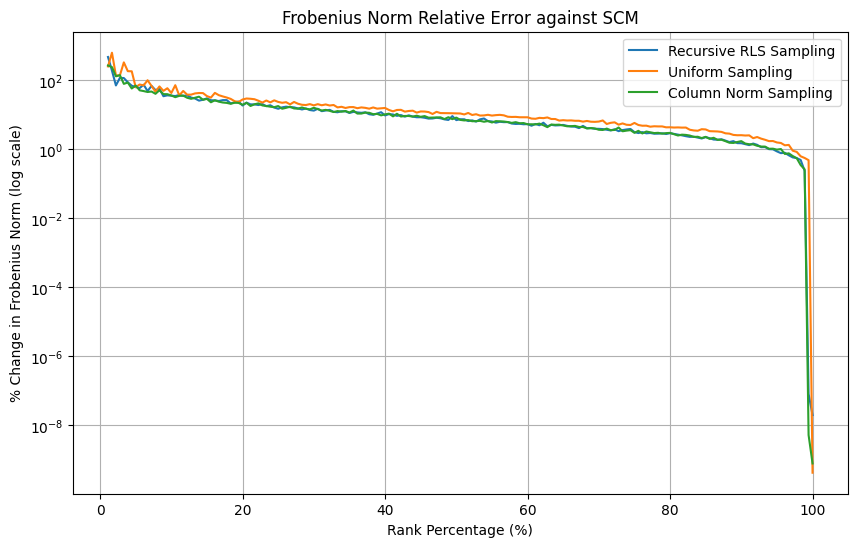

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def frobenius_norm_difference(A, B):
    """Calculate the relative Frobenius norm of the difference between two matrices."""
    return np.linalg.norm(A - B, 'fro') / np.linalg.norm(A, 'fro') * 100

def frobenius_norm_test(X, Sigma, rank_start=2, rank_end=260):
    """
    Compute the Frobenius norm difference between the Nyström covariance estimator
    and the sample covariance matrix for different sampling methods and ranks.

    Parameters:
    X (numpy.ndarray): The input data matrix.
    Sigma (numpy.ndarray): The sample covariance matrix.
    rank_start (int): The starting rank for the test (default: 2).
    rank_end (int): The ending rank for the test (default: 260).

    Returns:
    tuple: A tuple containing:
        - ranks (numpy.ndarray): The array of ranks tested.
        - frob_diffs (dict): A dictionary with sampling methods as keys and lists of
          Frobenius norm differences as values.
    """
    ranks = np.arange(rank_start, rank_end + 1)
    sampling_methods = {
        'Recursive RLS Sampling': recursive_rls_sample,
        'Uniform Sampling': uniform_random_sample,
        'Column Norm Sampling': column_norm_sample
    }

    frob_diffs = {method_name: [] for method_name in sampling_methods.keys()}

    for r in ranks:
        for method_name, method_func in sampling_methods.items():
            indices = method_func(X, num_landmarks=r)
            Sigma_hat = nystrom_covariance_estimator(X, indices)
            diff = frobenius_norm_difference(Sigma_hat, Sigma)
            frob_diffs[method_name].append(diff)

    return ranks, frob_diffs

def plot_frobenius_differences(ranks, frob_diffs):
    """
    Plot the Frobenius norm differences for different sampling methods against rank percentage.
    The plot uses a log scale with a drop to 0 from 10^0.

    Parameters:
    ranks (numpy.ndarray): The array of ranks tested.
    frob_diffs (dict): A dictionary with sampling methods as keys and lists of
                       Frobenius norm differences as values.
    """
    plt.figure(figsize=(10, 6))
    rank_percentage = ranks / np.max(ranks) * 100  # Rank as a percentage of max rank

    for method_name, diffs in frob_diffs.items():
        diffs = np.array(diffs)
        plt.semilogy(rank_percentage, diffs, label=method_name)

    plt.xlabel('Rank Percentage (%)')
    plt.ylabel('% Change in Frobenius Norm (log scale)')
    plt.title('Frobenius Norm Relative Error against SCM')
    plt.legend()
    plt.grid(True)

    # Set y-axis to log scale with a drop to 0
    plt.ylim(bottom=0)  # This will include 0 in the y-axis
    plt.yscale('symlog', linthresh=1e0)  # Use symlog scale with linear region below 10^0

    # Add horizontal line at y=10^0 to show where the scale changes
    plt.axhline(y=1e0, color='gray', linestyle='--', alpha=0.5)

    # Add vertical lines for 5% and 1% in the y-axis
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)

    # Add text annotations for the vertical lines
    plt.text(plt.xlim()[1], 5, '5%', va='center', ha='left', color='red')
    plt.text(plt.xlim()[1], 1, '1%', va='center', ha='left', color='red')

    plt.tight_layout()
    plt.show()

# Load the data and compute the sample covariance matrix
X = pd.read_pickle('russell_minute_data.pkl').values
Sigma = sample_covariance_estimator(X)

# Perform the Frobenius norm test and plot the results
ranks, frob_diffs = frobenius_norm_test(X, Sigma, rank_start=2, rank_end=180)
plot_frobenius_differences(ranks, frob_diffs)


#### Spectral Norm Difference

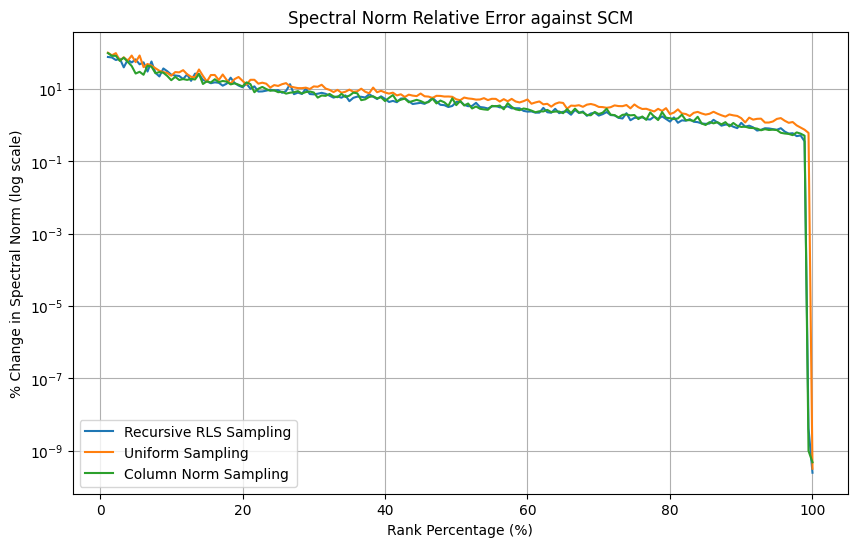

In [28]:
import matplotlib.pyplot as plt

# Load the data and compute the sample covariance matrix
X = pd.read_pickle('russell_minute_data.pkl').values
Sigma = sample_covariance_estimator(X)
Sigma_norm = np.linalg.norm(Sigma, ord=2)

def spectral_norm_difference(A, B, Sigma_norm=Sigma_norm):
    """
    Compute the spectral norm difference between two matrices A and B.
    """
    return np.linalg.norm(A - B, ord=2) / Sigma_norm * 100

def spectral_norm_test(X, Sigma, rank_start=2, rank_end=150):
    """
    Perform spectral norm test for different sampling methods and ranks.

    Parameters:
    X (numpy.ndarray): The data matrix
    Sigma (numpy.ndarray): The sample covariance matrix
    rank_start (int): The starting rank for testing
    rank_end (int): The ending rank for testing (default is None, which uses min(X.shape))

    Returns:
    tuple: (ranks, spectral_diffs)
        ranks (numpy.ndarray): The array of ranks tested
        spectral_diffs (dict): A dictionary with sampling methods as keys and lists of
                               spectral norm differences as values
    """

    ranks = np.arange(rank_start, rank_end + 1)

    sampling_methods = {
        'Recursive RLS Sampling': recursive_rls_sample,
        'Uniform Sampling': uniform_random_sample,
        'Column Norm Sampling': column_norm_sample
    }

    spectral_diffs = {method_name: [] for method_name in sampling_methods.keys()}

    for r in ranks:
        for method_name, method_func in sampling_methods.items():
            indices = method_func(X, num_landmarks=r)
            Sigma_hat = nystrom_covariance_estimator(X, indices)
            diff = spectral_norm_difference(Sigma_hat, Sigma)
            spectral_diffs[method_name].append(diff)

    return ranks, spectral_diffs

def plot_spectral_differences(ranks, spectral_diffs):
    """
    Plot the spectral norm differences for different sampling methods against rank percentage.
    The plot uses a log scale with a drop to 0 from 10^0.

    Parameters:
    ranks (numpy.ndarray): The array of ranks tested.
    spectral_diffs (dict): A dictionary with sampling methods as keys and lists of
                           spectral norm differences as values.
    """
    plt.figure(figsize=(10, 6))
    rank_percentage = ranks / np.max(ranks) * 100  # Rank as a percentage of max rank

    for method_name, diffs in spectral_diffs.items():
        diffs = np.array(diffs)
        plt.semilogy(rank_percentage, diffs, label=method_name)

    plt.xlabel('Rank Percentage (%)')
    plt.ylabel('% Change in Spectral Norm (log scale)')
    plt.title('Spectral Norm Relative Error against SCM')
    plt.legend()
    plt.grid(True)

    # Set y-axis to log scale with a drop to 0
    plt.ylim(bottom=0)  # This will include 0 in the y-axis
    plt.yscale('symlog', linthresh=1e0)  # Use symlog scale with linear region below 10^0

    # Add horizontal line at y=10^0 to show where the scale changes
    plt.axhline(y=1e0, color='gray', linestyle='--', alpha=0.5)

    # Add horizontal lines for 5% and 1% in the y-axis
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    # Add text annotations for the horizontal lines
    plt.text(plt.xlim()[1], 5, '5%', va='center', ha='left', color='red')
    plt.text(plt.xlim()[1], 1, '1%', va='center', ha='left', color='red')

    plt.tight_layout()
    plt.show()
    

ranks, spectral_diffs = spectral_norm_test(X, Sigma, rank_start=2, rank_end=150)
plot_spectral_differences(ranks, spectral_diffs)



#### Condition Number Comparison

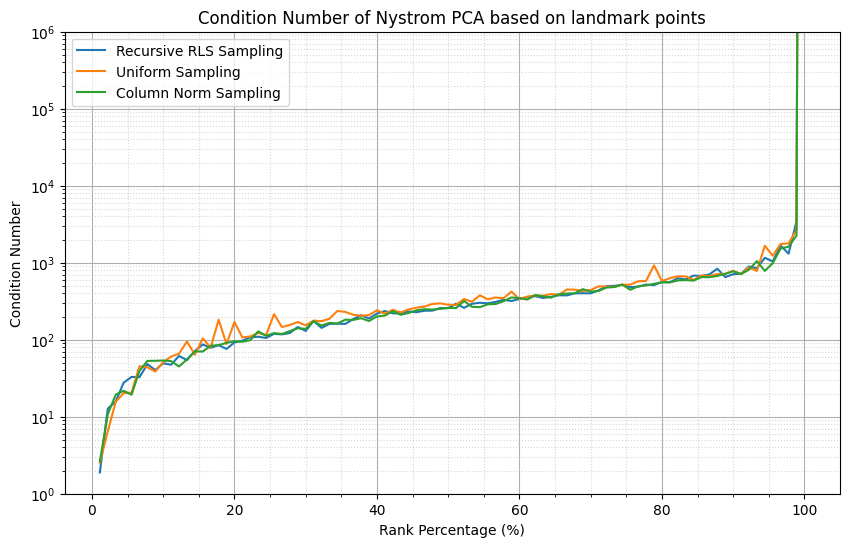

In [110]:
def condition_number_test(X, rank_start=2, rank_end=180, step=2):
    """
    Test the condition number of Nystrom PCA for different sampling methods and ranks.

    Parameters:
    X (numpy.ndarray): The input data matrix.
    rank_start (int): The starting rank for testing.
    rank_end (int): The ending rank for testing.
    step (int): The step size for ranks.

    Returns:
    numpy.ndarray: Array of ranks tested.
    dict: Dictionary with sampling methods as keys and lists of condition numbers as values.
    """
    n, d = X.shape
    ranks = np.arange(rank_start, min(rank_end, d, n) + 1, step)
    
    sampling_methods = {
        'Recursive RLS Sampling': recursive_rls_sample,
        'Uniform Sampling': uniform_random_sample,
        'Column Norm Sampling': column_norm_sample
    }
    
    condition_numbers = {method: [] for method in sampling_methods}
    
    for r in ranks:
        for method_name, method_func in sampling_methods.items():
            indices = method_func(X, num_landmarks=r)
            eigenvalues, eigenvectors = nystrom_pca(X, indices, r)
            
            # Compute condition number (ratio of largest to smallest eigenvalue)
            condition_number = np.max(eigenvalues) / np.min(eigenvalues)
            
            condition_numbers[method_name].append(condition_number)
    
    return ranks, condition_numbers

def plot_condition_numbers(ranks, condition_numbers):
    """
    Plot the condition numbers for different sampling methods against rank percentage.

    Parameters:
    ranks (numpy.ndarray): The array of ranks tested.
    condition_numbers (dict): A dictionary with sampling methods as keys and lists of
                              condition numbers as values.
    """
    plt.figure(figsize=(10, 6))
    for method_name, cond_nums in condition_numbers.items():
        rank_percentage = ranks / np.max(ranks) * 100  # Rank as a percentage of max rank
        plt.plot(rank_percentage, cond_nums, label=method_name)
    
    plt.xlabel('Rank Percentage (%)')
    plt.ylabel('Condition Number')
    plt.title('Condition Number of Nystrom PCA based on landmark points')
    plt.legend()
    plt.grid(True)
    
    # Set y-axis to logarithmic scale
    plt.yscale('log')
    
    # Set y-axis limits to focus on lower end
    plt.ylim(bottom=1, top=1e6)  # Adjust these values as needed
    
    # Add minor grid lines for better readability
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', alpha=0.5)
    
    plt.show()

# Perform the condition number test and plot the results
ranks, condition_numbers = condition_number_test(X, rank_start=2, rank_end=180)
plot_condition_numbers(ranks, condition_numbers)



In [39]:
X = pd.read_pickle('russell_minute_data.pkl').values
true_cov = sample_covariance_estimator(X)
# Calculate the condition number of the true covariance matrix
true_eigenvalues = np.linalg.eigvals(true_cov)
true_condition_number = np.max(true_eigenvalues) / np.min(true_eigenvalues)

print(f"Condition number of the true covariance matrix: {true_condition_number:.2e}")


Condition number of the true covariance matrix: -1.21e+16-0.00e+00j


#### Correlation Matrix Comparison Test

/var/folders/85/xp45dt5j04s4zr5n2396mrpr0000gn/T/ipykernel_77467/2338667733.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)  # This will include 0 in the y-axis


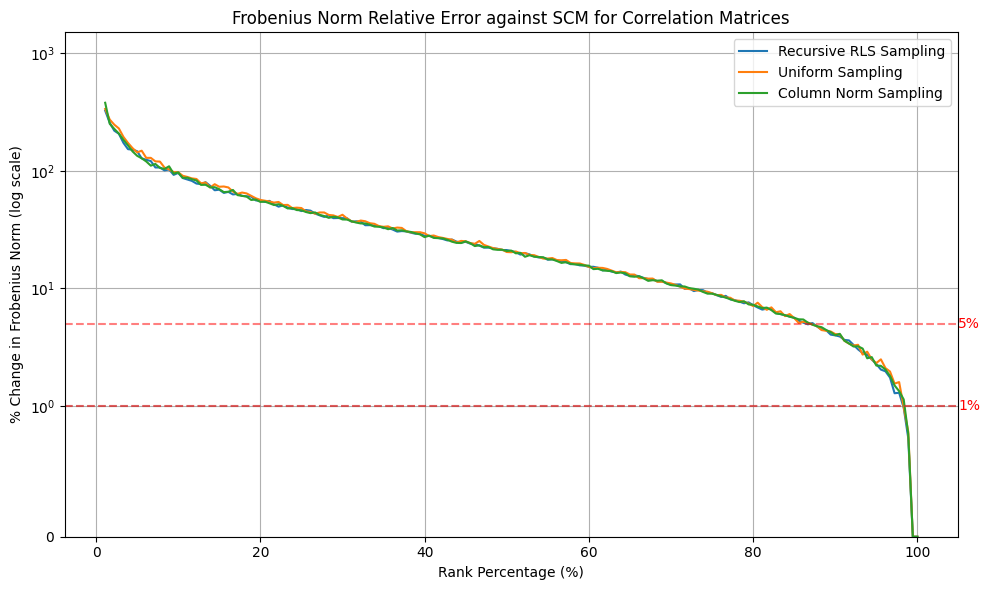

In [38]:
#### Correlation Matrix Comparison Test

def frobenius_norm_difference(A, B):
    """Calculate the relative Frobenius norm of the difference between two matrices."""
    return np.linalg.norm(A - B, 'fro') / np.linalg.norm(A, 'fro') * 100


def covariance_to_correlation(covariance_matrix):
    """
    Convert a covariance matrix to a correlation matrix.

    Parameters:
    covariance_matrix (numpy.ndarray): The covariance matrix to convert.

    Returns:
    numpy.ndarray: The correlation matrix.
    """
    # Calculate the standard deviations for each variable
    std_devs = np.sqrt(np.diag(covariance_matrix))
    
    # Handle zero standard deviations
    std_devs[std_devs == 0] = 1  # Replace zeros with ones to avoid division by zero
    
    # Create a diagonal matrix of the inverse of standard deviations
    inv_std_devs = np.diag(1 / std_devs)
    
    # Calculate the correlation matrix
    correlation_matrix = inv_std_devs @ covariance_matrix @ inv_std_devs
    
    # Ensure the diagonal is exactly 1 (to handle numerical precision issues)
    np.fill_diagonal(correlation_matrix, 1)
    
    return correlation_matrix

def correlation_matrix_comparison(rank_start, X, true_corr, rank_end):
    """
    Compare the correlation matrices obtained from different sampling methods.

    Parameters:
    X (numpy.ndarray): The input data matrix.
    sampling_methods (dict): A dictionary of sampling methods.
    num_landmarks (int): The number of landmarks to use for Nyström approximation.

    Returns:
    dict: A dictionary containing the correlation matrices for each method.
    """
    # Calculate the true correlation matrix
    
    # Example usage:
    sampling_methods = {
        'Recursive RLS Sampling': recursive_rls_sample,
        'Uniform Sampling': uniform_random_sample,
        'Column Norm Sampling': column_norm_sample
    }
    
    ranks = np.arange(rank_start, rank_end + 1)
    correlation_matrices = {}
    for method_name, method_func in sampling_methods.items():
        correlation_matrices[method_name] = []
        for rank in ranks:
            indices = method_func(X, num_landmarks=rank)
            nystrom_cov = nystrom_covariance_estimator(X, indices)
            nystrom_corr = covariance_to_correlation(nystrom_cov)
            frobenius_norm_diff = frobenius_norm_difference(true_corr, nystrom_corr)
            correlation_matrices[method_name].append(frobenius_norm_diff)
    
    return ranks, correlation_matrices

def plot_frobenius_differences(ranks, frob_diffs):
    """
    Plot the Frobenius norm differences for different sampling methods against rank percentage.
    The plot uses a log scale with a drop to 0 from 10^0.

    Parameters:
    ranks (numpy.ndarray): The array of ranks tested.
    frob_diffs (dict): A dictionary with sampling methods as keys and lists of
                       Frobenius norm differences as values.
    """
    plt.figure(figsize=(10, 6))
    rank_percentage = ranks / np.max(ranks) * 100  # Rank as a percentage of max rank

    for method_name, diffs in frob_diffs.items():
        diffs = np.array(diffs)
        plt.semilogy(rank_percentage, diffs, label=method_name)

    plt.xlabel('Rank Percentage (%)')
    plt.ylabel('% Change in Frobenius Norm (log scale)')
    plt.title('Frobenius Norm Relative Error against SCM for Correlation Matrices')
    plt.legend()
    plt.grid(True)

    # Set y-axis to log scale with a drop to 0
    plt.ylim(bottom=0)  # This will include 0 in the y-axis
    plt.yscale('symlog', linthresh=1e0)  # Use symlog scale with linear region below 10^0

    # Add horizontal line at y=10^0 to show where the scale changes
    plt.axhline(y=1e0, color='gray', linestyle='--', alpha=0.5)

    # Add horizontal lines for 5% and 1% in the y-axis
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    # Add text annotations for the horizontal lines
    plt.text(plt.xlim()[1], 5, '5%', va='center', ha='left', color='red')
    plt.text(plt.xlim()[1], 1, '1%', va='center', ha='left', color='red')

    plt.tight_layout()
    plt.show()

X = pd.read_pickle('russell_minute_data.pkl').values
true_cov = sample_covariance_estimator(X)
true_corr = covariance_to_correlation(true_cov)
num_landmarks = 50  # You can adjust this value
ranks, correlation_matrices = correlation_matrix_comparison(2, X, true_corr, 180)
plot_frobenius_differences(ranks, correlation_matrices)
# You can now use these correlation matrices for further analysis or visualization


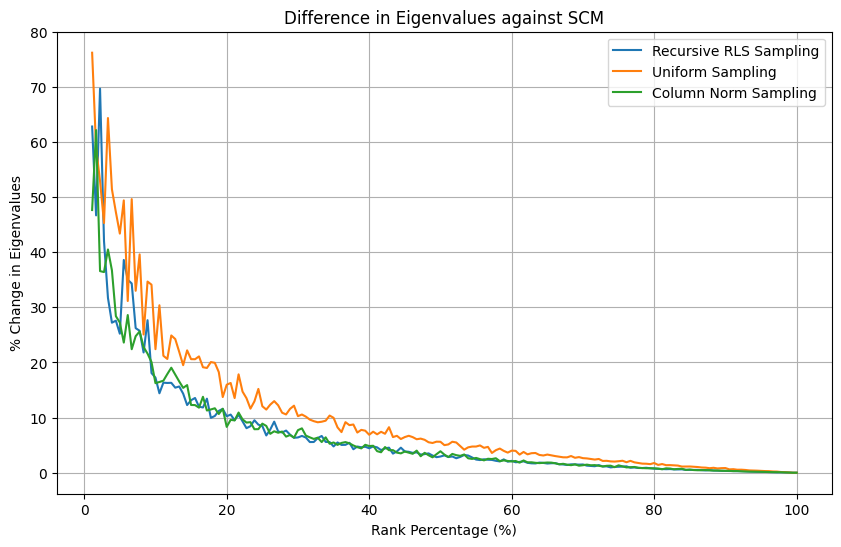

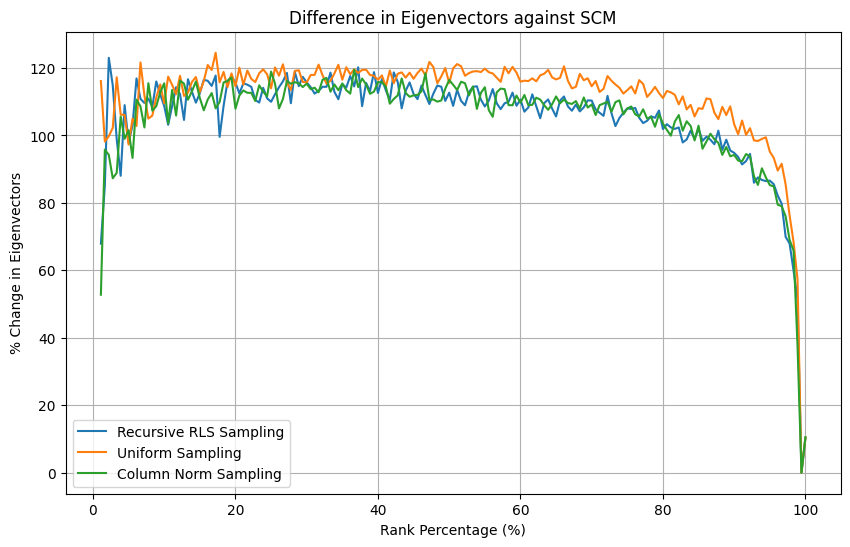

In [90]:
# Eigenvectors and Eigenvalues
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compare_eigenvalues(eigvals_sample, eigvals_nystrom, k):
    eigvals_sample = eigvals_sample[:k]
    eigvals_nystrom = eigvals_nystrom[:k]
    relative_error = np.linalg.norm(eigvals_sample - eigvals_nystrom) / np.linalg.norm(eigvals_sample) * 100
    return relative_error

def compare_eigenvectors(eigvecs_sample, eigvecs_nystrom, k):
    eigvecs_sample = eigvecs_sample[:, :k]
    eigvecs_nystrom = eigvecs_nystrom[:, :k]
    # Adjust signs
    for i in range(eigvecs_sample.shape[1]):
        if np.dot(eigvecs_sample[:, i], eigvecs_nystrom[:, i]) < 0:
            eigvecs_nystrom[:, i] *= -1
    
    frobenius_norm = np.linalg.norm(eigvecs_sample - eigvecs_nystrom, 'fro') / np.linalg.norm(eigvecs_sample, 'fro') * 100
    return frobenius_norm

def sample_svd(X):
    """
    Estimates the sample covariance matrix of a data matrix.
    """
    n = X.shape[0]  # Changed from X.shape[1] to X.shape[0]
    U_Y, D_Y, V_Y_T = np.linalg.svd(X, full_matrices=False)
    eigenvalues = D_Y**2 / n
    eigenvectors = V_Y_T.T

    return eigenvalues, eigenvectors

def eigen_test(X, rank_start=2, rank_end=180):
    ranks = np.arange(rank_start, rank_end + 1)
    sampling_methods = {
        'Recursive RLS Sampling': recursive_rls_sample,
        'Uniform Sampling': uniform_random_sample,
        'Column Norm Sampling': column_norm_sample
    }

    true_eigenvalues, true_eigenvectors = sample_svd(X)

    eigenvalue_diffs = {method_name: [] for method_name in sampling_methods.keys()}
    eigenvector_diffs = {method_name: [] for method_name in sampling_methods.keys()}

    for r in ranks:
        for method_name, method_func in sampling_methods.items():
            indices = method_func(X, num_landmarks=r)
            eigenvalues_hat, eigenvectors_hat = nystrom_pca(X, indices, r)
            
            # Calculate differences
            eigenvalue_diff = compare_eigenvalues(true_eigenvalues, eigenvalues_hat, r)
            eigenvector_diff = compare_eigenvectors(true_eigenvectors, eigenvectors_hat, r)
            
            # Record differences
            eigenvalue_diffs[method_name].append(eigenvalue_diff)
            eigenvector_diffs[method_name].append(eigenvector_diff)

    return ranks, eigenvalue_diffs, eigenvector_diffs

def plot_differences(ranks, diffs, ylabel, title):
    plt.figure(figsize=(10, 6))
    rank_percentage = ranks / np.max(ranks) * 100  # Rank as a percentage of max rank

    for method_name, diff_values in diffs.items():
        plt.plot(rank_percentage, diff_values, label=method_name)

    plt.xlabel('Rank Percentage (%)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Set y-axis to log scale with a drop to 0
    plt.ylim(bottom=0)  # This will include 0 in the y-axis

    # Add horizontal line at y=10^0 to show where the scale changes
    plt.axhline(y=1e0, color='gray', linestyle='--', alpha=0.5)

    # Add horizontal lines for 5% and 1% in the y-axis
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    # Add text annotations for the horizontal lines
    plt.text(plt.xlim()[1], 5, '5%', va='center', ha='left', color='red')
    plt.text(plt.xlim()[1], 1, '1%', va='center', ha='left', color='red')

    plt.tight_layout()
    plt.show()

X = pd.read_pickle('russell_minute_data.pkl').values
# Example of how to use the functions
ranks, eigenvalue_diffs, eigenvector_diffs = eigen_test(X)

# Plotting the differences in eigenvalues
plot_differences(ranks, eigenvalue_diffs, ylabel='% Change in Eigenvalues', title='Difference in Eigenvalues against SCM')

# Plotting the differences in eigenvectors
plot_differences(ranks, eigenvector_diffs, ylabel='% Change in Eigenvectors', title='Difference in Eigenvectors against SCM')

Finished 10 iterations
Finished 20 iterations
Finished 30 iterations


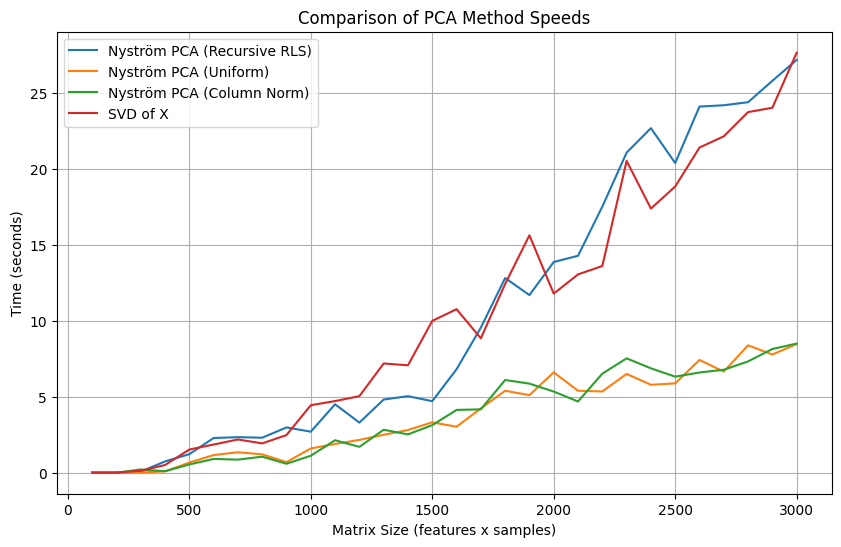

Results saved to 'pca_comparison_results.csv'


In [9]:
# Time Complexity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer


def sample_svd(X):
    """
    Estimates the sample covariance matrix of a data matrix.
    """
    n = X.shape[0]  # Changed from X.shape[1] to X.shape[0]
    U_Y, D_Y, V_Y_T = np.linalg.svd(X.T, full_matrices=False)  # Transposed X
    eigenvalues = D_Y**2 / n
    eigenvectors = U_Y

    return eigenvalues, eigenvectors
# Assuming the following functions are defined:
# - generate_low_rank_data(p, n, rank): generates a low-rank matrix
# - nystrom_pca(X, indices): performs Nyström PCA using given indices
# - cholesky_sample(X, num_landmarks): returns indices based on Cholesky sampling
# - uniform_random_sample(X, num_landmarks): returns indices based on random sampling
# - column_norm_sample(X, num_landmarks): returns indices based on column norm sampling
# - sample_eigenvalues_eigenmatrices(X): performs traditional PCA

def compare_pca_methods(max_size, step):
    sizes = range(step, max_size + 1, step)
    
    times_nystrom_rls = []
    times_nystrom_random = []
    times_nystrom_column = []
    times_sample = []
    matrix_sizes = []
    i = 0
    
    for size in sizes:
        i += 1
        n = size
        p = size // 2
        rank = size // 5

        # Generate a low rank data matrix
        X = generate_low_rank_data(n, p, rank)
        # Nyström PCA (Recursive RLS Sampling)
        start_time = timer()
        indices_rls = recursive_rls_sample(X, num_landmarks=rank)
        nystrom_pca(X, indices_rls, rank)
        end_time = timer()
        times_nystrom_rls.append(end_time - start_time)

        # Nyström PCA (Random sampling)
        start_time = timer()
        indices_random = uniform_random_sample(X, num_landmarks=rank)
        nystrom_pca(X, indices_random, rank)
        end_time = timer()
        times_nystrom_random.append(end_time - start_time)

        # Nyström PCA (Column Norm sampling)
        start_time = timer()
        indices_column = column_norm_sample(X, num_landmarks=rank)
        nystrom_pca(X, indices_column, rank)    
        end_time = timer()
        times_nystrom_column.append(end_time - start_time)

        # Traditional PCA
        start_time = timer()
        sample_svd(X)
        end_time = timer()
        times_sample.append(end_time - start_time)

        # Store the matrix size for each measurement
        matrix_sizes.append(size)

        if i % 10 == 0:
            print(f"Finished {i} iterations")

    # Create a DataFrame to store the results
    df_results = pd.DataFrame({
        'Matrix_Size': matrix_sizes,
        'Recursive RLS Sampling': times_nystrom_rls,
        'Uniform Sampling': times_nystrom_random,
        'Column Rank Sampling': times_nystrom_column,
        'SVD of X': times_sample
    })

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(df_results['Matrix_Size'], df_results['Recursive RLS Sampling'], label='Nyström PCA (Recursive RLS)')
    plt.plot(df_results['Matrix_Size'], df_results['Uniform Sampling'], label='Nyström PCA (Uniform)')
    plt.plot(df_results['Matrix_Size'], df_results['Column Rank Sampling'], label='Nyström PCA (Column Norm)')
    plt.plot(df_results['Matrix_Size'], df_results['SVD of X'], label='SVD of X')
    plt.xlabel('Matrix Size (features x samples)')
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of PCA Method Speeds')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_results

# Parameters
max_matrix_size = 3000  # maximum size of the matrix
step_size = 100         # step size for increasing matrix size

# Compare the different PCA methods and get the DataFrame
df_results = compare_pca_methods(max_matrix_size, step_size)

# Save the results to a CSV file
df_results.to_csv('pca_comparison_results.csv', index=False)

print("Results saved to 'pca_comparison_results.csv'")